In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import networkx as nx
from IPython.display import display, clear_output
from scipy import signal
from scipy import fftpack
from numpy.fft import fft, fftfreq
import os

# import custom module
import SIRS

In [2]:
# needed only if you made some changes at SIRS.py and want to import the updated version of the module
from importlib import reload
reload(SIRS)

<module 'SIRS' from '/home/clara/OneDrive/Università/Terzo Semestre/Life Data Epidemiology/LDE_project/LifeDataEpidemiology/SIRS.py'>

# LOOKING FOR CRITICAL VALUES OF THE DESEASE PARAMETERS

These parameters correspond to those of seasonal flu, in particular:

$$R_0 \in [0.9, 2.1]$$
recovery time $\in$ [5,7] so
$$\rightarrow \mu \in [0.143,0.2]$$
probability of contagion GIVEN contact 
$$\beta = R_0 \mu \in [0.128, 0.42]$$


If we raughly consider averages this value of $\beta$, in order to be used in our framework including topology, must be divided by the mean degree of the network $<k>$, so that $\widetilde{\beta} = \frac{\beta}{<k>}$ and the probability that a susceptible node gets infected can be computed as  
$P(I \rightarrow S) = \widetilde{\beta} \cdot [number\_of\_susceptible\_neightbours]$

In [16]:
#mobility and topology parameters
N = 1000
I_sf_init = 5
I_er_init = 5
p_mob = 0
mean_degree = 4
eps = 0.1 

In [17]:
# prepare systems
state_sf_init, state_er_init, variables_net_sf, variables_net_er = SIRS.prepare_two_sys(N, I_sf_init, I_er_init, 
                                                                              p_mob, mean_degree)

#computing network
sf_net = variables_net_sf["original_sf_net"]
dg_sf = np.array([k for n,k in sf_net.degree()])
mean_dg_sf = np.mean(dg_sf)
sq_mean_dg_sf = np.mean(np.power(dg_sf,2))

threshold_sf = mean_dg_sf/(sq_mean_dg_sf - mean_dg_sf)
print("Mean dg of SF net:", mean_dg_sf)
print("Threshold using block degree approximation for SF net:", threshold_sf)

er_net = variables_net_er["original_er_net"]
dg_er = np.array([k for n,k in er_net.degree()])
mean_dg_er = np.mean(dg_er)
threshold_er = 1/mean_dg_er
print("Mean dg of ER net:", mean_dg_er)
print("Threshold using block degree approximation for ER net:", threshold_er)

print("Number of travelling nodes in ER:", len(variables_net_er["travellers_er"]))
print("Number of travelling nodes in SF:", len(variables_net_sf["travellers_sf"]))

Mean dg of SF net: 3.992
Threshold using block degree approximation for SF net: 0.10746782964518387
Mean dg of ER net: 4.136
Threshold using block degree approximation for ER net: 0.24177949709864602
Number of travelling nodes in ER: 0
Number of travelling nodes in SF: 0


In [11]:
#epidemics values
beta = 0.25/mean_degree #mean degree of generated networks is usually a little smaller
mu = 0.14
gamma = 0.015

R_0 = beta/mu
    
print("Basic Reproductive Ratio (taking into account topology):", R_0)

infection_params = dict(beta=beta, mu=mu, gamma=gamma)

Basic Reproductive Ratio (taking into account topology): 0.4464285714285714


This $\gamma$ value corresponds to an average time for going from R to S of 60 "days".

In [23]:
n_runs = 50
n_iter = 1000

directory_name = str(mu)+"_"+str(beta)+"_"+str(gamma) 
os.system("mkdir "+directory_name)


S_tot_er=0*(n_iter+1)
I_tot_er=0*(n_iter+1)
R_tot_er=0*(n_iter+1)
S_tot_sf=0*(n_iter+1)
I_tot_sf=0*(n_iter+1)
R_tot_sf=0*(n_iter+1)


for run in range(n_runs):    
    
    state_sf = np.copy(state_sf_init)
    state_er = np.copy(state_er_init)

    import time 
    start = time.time()
    S_sf = [N - I_sf_init]
    I_sf = [I_sf_init]
    R_sf = [0]
    S_er = [N - I_er_init]
    I_er = [I_er_init]
    R_er = [0]
    t_vec = []
    for i in range(n_iter):
        state_sf, state_er = SIRS.two_sys_full_SIRS_step(state_sf, state_er, **variables_net_sf, 
                                                **variables_net_er, **infection_params)
        S_sf.append(state_sf[:,0].sum())
        I_sf.append(state_sf[:,1].sum())
        R_sf.append(state_sf[:,2].sum())
        S_er.append(state_er[:,0].sum())
        I_er.append(state_er[:,1].sum())
        R_er.append(state_er[:,2].sum())
        t_vec.append(time.time()-start)

    tot_time = time.time()-start
    print("Total time elapsed: %.2f s"%tot_time)
    print("Time per iteration: %.4f s"%(tot_time/n_iter))

    S_sf = np.array(S_sf)
    I_sf = np.array(I_sf)
    R_sf = np.array(R_sf)
    S_er = np.array(S_er)
    I_er = np.array(I_er)
    R_er = np.array(R_er)
    t_vec = np.array(t_vec)
    
    S_tot_sf+=S_sf
    I_tot_sf+=I_sf
    R_tot_sf+=R_sf
    S_tot_er+=S_er
    I_tot_er+=I_er
    R_tot_er+=R_er

    indexes = np.arange(n_iter+1)
    fig, ax = plt.subplots(1,2, figsize=(15,8))
    ax[0].plot(indexes, S_sf, label = r'$S_{sf}$')
    ax[0].plot(indexes, I_sf, label = r'$I_{sf}$')
    ax[0].plot(indexes, R_sf, label = r'$R_{sf}$')
    ax[0].plot(indexes, S_sf+I_sf+R_sf, label = 'tot')
    ax[0].set_xlabel('Number of iterations', fontsize = 16)
    ax[0].set_ylabel('Number of individuals', fontsize = 16)
    ax[0].set_title("Scale-free network", fontsize = 16)
    ax[0].legend(fontsize=13, loc='upper right')

    ax[1].plot(indexes, S_er, label = r'$S_{er}$')
    ax[1].plot(indexes, I_er, label = r'$I_{er}$')
    ax[1].plot(indexes, R_er, label = r'$R_{er}$')
    ax[1].plot(indexes, S_er+I_er+R_er, label = 'tot')
    ax[1].set_title("Erdosh-Renyi network", fontsize = 16)
    ax[1].set_xlabel('Number of iterations', fontsize = 16)
    ax[1].set_ylabel('Number of individuals', fontsize = 16)
    ax[1].legend(fontsize=13, loc='upper right')

    plt.suptitle(r"$\mu= {:.3f}; \beta= {:.3f}; \gamma= {:.3f}$".format(mu, beta, gamma), fontsize=20)

    save=directory_name+"/run_"+str(run)+".png"
    fig.savefig(save)
    plt.close()
    

fig, ax = plt.subplots(1,2, figsize=(15,8))
ax[0].plot(indexes, S_tot_sf/n_runs, label = r'$S_{sf}$')
ax[0].plot(indexes, I_tot_sf/n_runs, label = r'$I_{sf}$')
ax[0].plot(indexes, R_tot_sf/n_runs, label = r'$R_{sf}$')
ax[0].plot(indexes, (S_tot_sf+I_tot_sf+R_tot_sf)/n_runs, label = 'tot')
ax[0].set_xlabel('Number of iterations', fontsize = 16)
ax[0].set_ylabel('Number of individuals', fontsize = 16)
ax[0].set_title("Scale-free network", fontsize = 16)
ax[0].legend(fontsize=13, loc='upper right')

ax[1].plot(indexes, S_tot_er/n_runs, label = r'$S_{er}$')
ax[1].plot(indexes, I_tot_er/n_runs, label = r'$I_{er}$')
ax[1].plot(indexes, R_tot_er/n_runs, label = r'$R_{er}$')
ax[1].plot(indexes, (S_tot_er+I_tot_er+R_tot_er)/n_runs, label = 'tot')
ax[1].set_title("Erdosh-Renyi network", fontsize = 16)
ax[1].set_xlabel('Number of iterations', fontsize = 16)
ax[1].set_ylabel('Number of individuals', fontsize = 16)
ax[1].legend(fontsize=13, loc='upper right')

plt.suptitle(r"Mean on {} runs, $\mu= {:.3f}; \beta= {:.3f}; \gamma= {:.3f}$".format(n_runs, mu, beta, gamma), fontsize=20)

save = directory_name+"/total.png"
fig.savefig(save)
plt.close()

Total time elapsed: 13.72 s
Time per iteration: 0.0137 s
Total time elapsed: 13.63 s
Time per iteration: 0.0136 s
Total time elapsed: 12.23 s
Time per iteration: 0.0122 s
Total time elapsed: 13.45 s
Time per iteration: 0.0135 s
Total time elapsed: 12.97 s
Time per iteration: 0.0130 s
Total time elapsed: 12.18 s
Time per iteration: 0.0122 s
Total time elapsed: 12.38 s
Time per iteration: 0.0124 s
Total time elapsed: 12.24 s
Time per iteration: 0.0122 s
Total time elapsed: 12.19 s
Time per iteration: 0.0122 s
Total time elapsed: 12.14 s
Time per iteration: 0.0121 s
Total time elapsed: 12.24 s
Time per iteration: 0.0122 s
Total time elapsed: 13.37 s
Time per iteration: 0.0134 s
Total time elapsed: 12.60 s
Time per iteration: 0.0126 s
Total time elapsed: 14.05 s
Time per iteration: 0.0141 s
Total time elapsed: 15.92 s
Time per iteration: 0.0159 s
Total time elapsed: 13.66 s
Time per iteration: 0.0137 s
Total time elapsed: 12.51 s
Time per iteration: 0.0125 s
Total time elapsed: 11.91 s
Tim

# STARTING TO EXPLORE MOBILITY: changing probability of travel p_mob

We fixed the epidemic parameters in a "critical" point at which most of the times the epidemics does not survive and dies out after some iterations. The topology of the two networks is also kept fixed. We now explore the role of the mobility parameter p_mob.

In [29]:
#mobility and topology parameters
N = 1000
I_sf_init = 5
I_er_init = 0
mean_degree = 4
eps = 0.1 

#epidemics values
beta = 0.25/mean_degree #mean degree of generated networks is usually a little smaller
mu = 0.14
gamma = 0.015

R_0 = beta/mu
    
print("Basic Reproductive Ratio (taking into account topology):", R_0)

infection_params = dict(beta=beta, mu=mu, gamma=gamma)

Basic Reproductive Ratio (taking into account topology): 0.4464285714285714


In [32]:
p_mob_list = np.linspace(0.02,0.07,10)

In [36]:
for p_mob in p_mob_list:
    
    print("P_mob:", p_mob)

    # prepare systems
    state_sf_init, state_er_init, variables_net_sf, variables_net_er = SIRS.prepare_two_sys(N, I_sf_init, I_er_init, 
                                                                                  p_mob, mean_degree)

    #computing network
    sf_net = variables_net_sf["original_sf_net"]
    dg_sf = np.array([k for n,k in sf_net.degree()])
    mean_dg_sf = np.mean(dg_sf)
    sq_mean_dg_sf = np.mean(np.power(dg_sf,2))

    threshold_sf = mean_dg_sf/(sq_mean_dg_sf - mean_dg_sf)
    '''print("Mean dg of SF net:", mean_dg_sf)
    print("Threshold using block degree approximation for SF net:", threshold_sf)'''

    er_net = variables_net_er["original_er_net"]
    dg_er = np.array([k for n,k in er_net.degree()])
    mean_dg_er = np.mean(dg_er)
    threshold_er = 1/mean_dg_er
    '''print("Mean dg of ER net:", mean_dg_er)
    print("Threshold using block degree approximation for ER net:", threshold_er)

    print("Number of travelling nodes in ER:", len(variables_net_er["travellers_er"]))
    print("Number of travelling nodes in SF:", len(variables_net_sf["travellers_sf"]))'''
    
    

    n_runs = 10
    n_iter = 1000

    directory_name = "pmob_"+"{:3f}".format(p_mob)
    os.system("mkdir "+directory_name)


    S_tot_er=0*(n_iter+1)
    I_tot_er=0*(n_iter+1)
    R_tot_er=0*(n_iter+1)
    S_tot_sf=0*(n_iter+1)
    I_tot_sf=0*(n_iter+1)
    R_tot_sf=0*(n_iter+1)


    for run in range(n_runs):  
        
        print("Iteration:", run)

        state_sf = np.copy(state_sf_init)
        state_er = np.copy(state_er_init)

        import time 
        start = time.time()
        S_sf = [N - I_sf_init]
        I_sf = [I_sf_init]
        R_sf = [0]
        S_er = [N - I_er_init]
        I_er = [I_er_init]
        R_er = [0]
        t_vec = []
        for i in range(n_iter):
            state_sf, state_er = SIRS.two_sys_full_SIRS_step(state_sf, state_er, **variables_net_sf, 
                                                    **variables_net_er, **infection_params)
            S_sf.append(state_sf[:,0].sum())
            I_sf.append(state_sf[:,1].sum())
            R_sf.append(state_sf[:,2].sum())
            S_er.append(state_er[:,0].sum())
            I_er.append(state_er[:,1].sum())
            R_er.append(state_er[:,2].sum())
            t_vec.append(time.time()-start)

        tot_time = time.time()-start
        print("Total time elapsed: %.2f s"%tot_time)
        print("Time per iteration: %.4f s"%(tot_time/n_iter))

        S_sf = np.array(S_sf)
        I_sf = np.array(I_sf)
        R_sf = np.array(R_sf)
        S_er = np.array(S_er)
        I_er = np.array(I_er)
        R_er = np.array(R_er)
        t_vec = np.array(t_vec)

        S_tot_sf+=S_sf
        I_tot_sf+=I_sf
        R_tot_sf+=R_sf
        S_tot_er+=S_er
        I_tot_er+=I_er
        R_tot_er+=R_er

        indexes = np.arange(n_iter+1)
        fig, ax = plt.subplots(1,2, figsize=(15,8))
        ax[0].plot(indexes, S_sf, label = r'$S_{sf}$')
        ax[0].plot(indexes, I_sf, label = r'$I_{sf}$')
        ax[0].plot(indexes, R_sf, label = r'$R_{sf}$')
        ax[0].plot(indexes, S_sf+I_sf+R_sf, label = 'tot')
        ax[0].set_xlabel('Number of iterations', fontsize = 16)
        ax[0].set_ylabel('Number of individuals', fontsize = 16)
        ax[0].set_title("Scale-free network", fontsize = 16)
        ax[0].legend(fontsize=13, loc='upper right')

        ax[1].plot(indexes, S_er, label = r'$S_{er}$')
        ax[1].plot(indexes, I_er, label = r'$I_{er}$')
        ax[1].plot(indexes, R_er, label = r'$R_{er}$')
        ax[1].plot(indexes, S_er+I_er+R_er, label = 'tot')
        ax[1].set_title("Erdosh-Renyi network", fontsize = 16)
        ax[1].set_xlabel('Number of iterations', fontsize = 16)
        ax[1].set_ylabel('Number of individuals', fontsize = 16)
        ax[1].legend(fontsize=13, loc='upper right')

        plt.suptitle(r"p_mob = {:.3f}; $\mu= {:.3f}; \beta= {:.3f}; \gamma= {:.3f}$".format(p_mob, mu, beta, gamma), fontsize=20)

        save=directory_name+"/run_"+str(run)+".png"
        fig.savefig(save)
        plt.close()


    fig, ax = plt.subplots(1,2, figsize=(15,8))
    ax[0].plot(indexes, S_tot_sf/n_runs, label = r'$S_{sf}$')
    ax[0].plot(indexes, I_tot_sf/n_runs, label = r'$I_{sf}$')
    ax[0].plot(indexes, R_tot_sf/n_runs, label = r'$R_{sf}$')
    ax[0].plot(indexes, (S_tot_sf+I_tot_sf+R_tot_sf)/n_runs, label = 'tot')
    ax[0].set_xlabel('Number of iterations', fontsize = 16)
    ax[0].set_ylabel('Number of individuals', fontsize = 16)
    ax[0].set_title("Scale-free network", fontsize = 16)
    ax[0].legend(fontsize=13, loc='upper right')

    ax[1].plot(indexes, S_tot_er/n_runs, label = r'$S_{er}$')
    ax[1].plot(indexes, I_tot_er/n_runs, label = r'$I_{er}$')
    ax[1].plot(indexes, R_tot_er/n_runs, label = r'$R_{er}$')
    ax[1].plot(indexes, (S_tot_er+I_tot_er+R_tot_er)/n_runs, label = 'tot')
    ax[1].set_title("Erdosh-Renyi network", fontsize = 16)
    ax[1].set_xlabel('Number of iterations', fontsize = 16)
    ax[1].set_ylabel('Number of individuals', fontsize = 16)
    ax[1].legend(fontsize=13, loc='upper right')

    plt.suptitle(r"Mean on {} runs, p_mob = {:.3f}; $\mu= {:.3f}; \beta= {:.3f}; \gamma= {:.3f}$".format(n_runs, p_mob, mu, beta, gamma), fontsize=20)

    save = directory_name+"/total_"+str(p_mob)+".png"
    fig.savefig(save)
    plt.close()

P_mob: 0.02
Iteration: 0
Total time elapsed: 23.29 s
Time per iteration: 0.0233 s
Iteration: 1
Total time elapsed: 26.47 s
Time per iteration: 0.0265 s
Iteration: 2
Total time elapsed: 22.62 s
Time per iteration: 0.0226 s
Iteration: 3
Total time elapsed: 19.69 s
Time per iteration: 0.0197 s
Iteration: 4
Total time elapsed: 19.62 s
Time per iteration: 0.0196 s
Iteration: 5
Total time elapsed: 22.19 s
Time per iteration: 0.0222 s
Iteration: 6
Total time elapsed: 23.96 s
Time per iteration: 0.0240 s
Iteration: 7
Total time elapsed: 23.96 s
Time per iteration: 0.0240 s
Iteration: 8
Total time elapsed: 25.22 s
Time per iteration: 0.0252 s
Iteration: 9
Total time elapsed: 21.75 s
Time per iteration: 0.0217 s
P_mob: 0.025555555555555557
Iteration: 0
Total time elapsed: 23.22 s
Time per iteration: 0.0232 s
Iteration: 1
Total time elapsed: 22.39 s
Time per iteration: 0.0224 s
Iteration: 2
Total time elapsed: 22.91 s
Time per iteration: 0.0229 s
Iteration: 3
Total time elapsed: 22.48 s
Time per 

KeyboardInterrupt: 

## ATTEMPTING SPECTRAL ANALYSIS

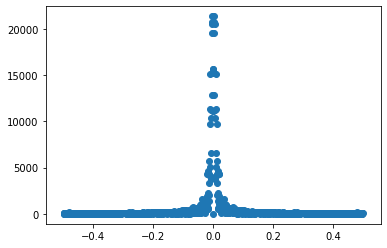

In [83]:
#take "t--> inf"
data = S_sf[500:]
#removing mean
mean = np.mean(data)
data = data - mean


#variables
N=len(data)
tmin=0
tmax=N
dt=(tmax-tmin)/N
T=dt*N
df = 1/T


#fft
yf = np.fft.fft(data)
freqs = np.fft.fftfreq(N)*df*N
f = np.array([df*n if n<N/2 else df*(n-N) for n in range(N)])
plt.scatter(f,np.abs(yf))
#plt.xlim(-0.1,0.1)
plt.show()
#plt.plot(freqs)

# BOZZE

## Codice

In [8]:
#prints values in time
for n, s,i,r in zip(np.arange(n_iter),S_sf,I_sf,R_sf): print(n, s,i,r)

0 995.0 5.0 0.0
1 993.0 7.0 0.0
2 989.0 10.0 1.0
3 978.0 21.0 1.0
4 967.0 30.0 3.0
5 956.0 40.0 4.0
6 940.0 53.0 7.0
7 916.0 74.0 10.0
8 878.0 107.0 15.0
9 838.0 141.0 21.0
10 787.0 184.0 29.0
11 737.0 225.0 38.0
12 666.0 278.0 56.0
13 609.0 310.0 81.0
14 543.0 354.0 103.0
15 480.0 379.0 141.0
16 444.0 392.0 164.0
17 396.0 413.0 191.0
18 363.0 418.0 219.0
19 336.0 408.0 256.0
20 306.0 405.0 289.0
21 283.0 392.0 325.0
22 269.0 375.0 356.0
23 251.0 364.0 385.0
24 244.0 359.0 397.0
25 226.0 356.0 418.0
26 217.0 332.0 451.0
27 206.0 325.0 469.0
28 197.0 315.0 488.0
29 190.0 303.0 507.0
30 181.0 294.0 525.0
31 178.0 280.0 542.0
32 175.0 254.0 571.0
33 180.0 236.0 584.0
34 175.0 225.0 600.0
35 171.0 211.0 618.0
36 170.0 198.0 632.0
37 174.0 190.0 636.0
38 175.0 175.0 650.0
39 180.0 159.0 661.0
40 186.0 149.0 665.0
41 193.0 144.0 663.0
42 195.0 135.0 670.0
43 191.0 130.0 679.0
44 195.0 122.0 683.0
45 196.0 116.0 688.0
46 200.0 101.0 699.0
47 202.0 97.0 701.0
48 208.0 90.0 702.0
49 212.0 87.0 

894 514.0 68.0 418.0
895 506.0 77.0 417.0
896 499.0 80.0 421.0
897 492.0 89.0 419.0
898 485.0 89.0 426.0
899 478.0 92.0 430.0
900 480.0 89.0 431.0
901 478.0 84.0 438.0
902 475.0 84.0 441.0
903 473.0 84.0 443.0
904 463.0 95.0 442.0
905 450.0 105.0 445.0
906 447.0 103.0 450.0
907 443.0 101.0 456.0
908 438.0 99.0 463.0
909 439.0 96.0 465.0
910 432.0 93.0 475.0
911 436.0 86.0 478.0
912 438.0 82.0 480.0
913 430.0 87.0 483.0
914 431.0 82.0 487.0
915 431.0 79.0 490.0
916 437.0 72.0 491.0
917 438.0 67.0 495.0
918 438.0 70.0 492.0
919 437.0 68.0 495.0
920 432.0 62.0 506.0
921 437.0 63.0 500.0
922 441.0 57.0 502.0
923 442.0 58.0 500.0
924 441.0 56.0 503.0
925 440.0 60.0 500.0
926 436.0 59.0 505.0
927 444.0 57.0 499.0
928 451.0 54.0 495.0
929 448.0 58.0 494.0
930 450.0 61.0 489.0
931 451.0 58.0 491.0
932 459.0 59.0 482.0
933 458.0 58.0 484.0
934 457.0 62.0 481.0
935 457.0 60.0 483.0
936 458.0 59.0 483.0
937 459.0 57.0 484.0
938 458.0 58.0 484.0
939 457.0 56.0 487.0
940 457.0 55.0 488.0
941 458.0 

1885 419.0 59.0 522.0
1886 417.0 61.0 522.0
1887 409.0 64.0 527.0
1888 411.0 63.0 526.0
1889 407.0 60.0 533.0
1890 408.0 58.0 534.0
1891 409.0 60.0 531.0
1892 408.0 58.0 534.0
1893 407.0 62.0 531.0
1894 407.0 57.0 536.0
1895 404.0 60.0 536.0
1896 396.0 66.0 538.0
1897 390.0 71.0 539.0
1898 390.0 71.0 539.0
1899 391.0 70.0 539.0
1900 392.0 74.0 534.0
1901 390.0 77.0 533.0
1902 387.0 77.0 536.0
1903 385.0 82.0 533.0
1904 385.0 80.0 535.0
1905 383.0 76.0 541.0
1906 383.0 76.0 541.0
1907 381.0 79.0 540.0
1908 381.0 77.0 542.0
1909 383.0 73.0 544.0
1910 385.0 70.0 545.0
1911 389.0 65.0 546.0
1912 394.0 63.0 543.0
1913 397.0 61.0 542.0
1914 395.0 62.0 543.0
1915 397.0 60.0 543.0
1916 402.0 57.0 541.0
1917 404.0 54.0 542.0
1918 405.0 54.0 541.0
1919 409.0 54.0 537.0
1920 408.0 53.0 539.0
1921 412.0 50.0 538.0
1922 412.0 52.0 536.0
1923 414.0 53.0 533.0
1924 415.0 49.0 536.0
1925 416.0 52.0 532.0
1926 417.0 50.0 533.0
1927 419.0 51.0 530.0
1928 417.0 54.0 529.0
1929 417.0 53.0 530.0
1930 415.0

2881 448.0 49.0 503.0
2882 444.0 54.0 502.0
2883 441.0 55.0 504.0
2884 443.0 53.0 504.0
2885 444.0 55.0 501.0
2886 445.0 52.0 503.0
2887 447.0 49.0 504.0
2888 452.0 47.0 501.0
2889 451.0 48.0 501.0
2890 451.0 49.0 500.0
2891 453.0 49.0 498.0
2892 454.0 47.0 499.0
2893 453.0 51.0 496.0
2894 454.0 48.0 498.0
2895 452.0 50.0 498.0
2896 457.0 49.0 494.0
2897 459.0 47.0 494.0
2898 465.0 42.0 493.0
2899 472.0 38.0 490.0
2900 473.0 37.0 490.0
2901 474.0 35.0 491.0
2902 474.0 34.0 492.0
2903 478.0 32.0 490.0
2904 484.0 26.0 490.0
2905 484.0 24.0 492.0
2906 485.0 20.0 495.0
2907 490.0 18.0 492.0
2908 497.0 17.0 486.0
2909 500.0 17.0 483.0
2910 507.0 19.0 474.0
2911 509.0 18.0 473.0
2912 517.0 18.0 465.0
2913 519.0 21.0 460.0
2914 521.0 22.0 457.0
2915 526.0 24.0 450.0
2916 529.0 23.0 448.0
2917 529.0 23.0 448.0
2918 533.0 21.0 446.0
2919 534.0 24.0 442.0
2920 538.0 22.0 440.0
2921 542.0 23.0 435.0
2922 546.0 21.0 433.0
2923 550.0 21.0 429.0
2924 549.0 21.0 430.0
2925 552.0 23.0 425.0
2926 561.0

In [9]:
#oscillation period for SIRS proces in endemic state
def oscillation_period(beta, mu, gamma):
    R_0 = beta/(mu)
    GI = 1/(mu)
    GR = 1/(gamma + mu)
    A = (gamma + mu)/(gamma*(beta - mu))
    '''print(4*(R_0 -1))
    print(GI*GR)
    print(4*(R_0 -1)/(GI*GR))
    print(1/GR)
    print(1/A)
    print((1/GR - 1/A)**2)'''
    
    return 4*np.pi/np.sqrt(4*(R_0 - 1)*(1/(GI*GR)) - (1/GR - 1/A)**2)

In [4]:
#threshold values in degree block approximation

state_sf, state_er, variables_net_sf, variables_net_er = SIRS.prepare_two_sys(N_out, I_sf_out, I_er_out, 
                                                                               p_mob_out, mean_degree_out)

sf_net = variables_net_sf["original_sf_net"]
dg_sf = np.array([k for n,k in sf_net.degree()])
mean_dg_sf = np.mean(dg_sf)
sq_mean_dg_sf = np.mean(np.power(dg_sf,2))

threshold_sf = mean_dg_sf/(sq_mean_dg_sf - mean_dg_sf)
print("Mean dg of SF net:", mean_dg_sf)
print("Threshold using block degree approximation for SF net:", threshold_sf)

er_net = variables_net_er["original_er_net"]
dg_er = np.array([k for n,k in er_net.degree()])
mean_dg_er = np.mean(dg_er)
threshold_er = 1/mean_dg_er
print("Mean dg of ER net:", mean_dg_er)
print("Threshold using block degree approximation for ER net:", threshold_er)

Mean dg of SF net: 3.992
Threshold using block degree approximation for SF net: 0.0957222328793401
Mean dg of ER net: 3.914
Threshold using block degree approximation for ER net: 0.25549310168625444


## Appunti

SIRS:

S ---> I with probability given contact $\beta$

I ---> R with probability per iteration $\mu$

R ---> S with ptobability per iteration $\gamma$

If $\gamma$ >> $\mu$ ---> SIS

If $\gamma$ $\simeq$ 0 ---> SIR